<a href="https://colab.research.google.com/github/AtSourav/AE-n-VAE-with-CB-loss-on-stl10/blob/main/AE_cifar10_mse_HeNormal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow import math
import tensorflow_datasets as tfds
from keras import losses
from keras import layers
from keras import utils
from keras import backend as K
from keras import initializers

import os
import random
import matplotlib.pyplot as plt

In [2]:
img_ht = 32
img_wd = 32

input_size = (img_ht,img_wd,3)
latent_dim = 200
batch_size = 128

#initializer = initializers.GlorotNormal()
initializer = initializers.HeNormal(seed=123)

In [3]:
ds = tfds.load('cifar10', split='train')
ds2= tfds.load('cifar10', split='test')

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/3.0.2.incompleteFCHB04/cifar10-train.tfrecord*...:   0%|          …

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/3.0.2.incompleteFCHB04/cifar10-test.tfrecord*...:   0%|          |…

Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


In [4]:
ds_to_np = list(ds.as_numpy_iterator())
ds2_to_np = list(ds2.as_numpy_iterator())

In [5]:
print(set(tuple(x.keys()) for x in ds_to_np))

print(set(x['label'] for x in ds_to_np))
print(set(type(x['image']) for x in ds_to_np))
print(set(x['image'].shape for x in ds_to_np))
print(len(ds_to_np))

{('id', 'image', 'label')}
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
{<class 'numpy.ndarray'>}
{(32, 32, 3)}
50000


In [6]:
img_train = np.array([x['image'] for x in ds_to_np])
img_valid = np.array([x['image'] for x in ds2_to_np])

img_train = img_train/255
img_valid = img_valid/255

In [15]:
encoder_input = keras.Input(shape=input_size)

x = layers.Conv2D(64, 3, padding="valid", kernel_initializer=initializer)(encoder_input)
x = layers.ReLU()(x)

x = layers.Conv2D(64, 3, padding="valid", kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding="valid")(x)

x = layers.Conv2D(128, 3, padding="valid", kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2D(128, 2, padding="valid", kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2D(128, 2, padding="valid", kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2D(128, 1, padding="valid", kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2D(256, 3, padding="valid", kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2D(256, 3, padding="valid", kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2D(256, 2, padding="valid", kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2D(256, 2, padding="valid", kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2D(256, 1, padding="valid", kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

#x = layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding="valid")(x)
x = layers.ReLU()(x)


x = layers.Conv2D(512, 2, padding="valid", kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2D(512, 2, padding="valid", kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2D(512, 1, padding="valid", kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2D(512, 1, padding="valid", kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

#x = layers.MaxPooling2D(pool_size=(2, 2), strides=1, padding="valid")(x)

x = layers.Flatten()(x)

x = layers.Dense(8*latent_dim)(x)
x = layers.ReLU()(x)

x = layers.Dense(4*latent_dim)(x)
x = layers.ReLU()(x)

x = layers.Dense(2*latent_dim)(x)
x = layers.ReLU()(x)


z = layers.Dense(latent_dim, name="z")(x)

encoder = keras.Model(encoder_input, z, name='encoder')
encoder.summary()



Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_50 (Conv2D)          (None, 30, 30, 64)        1792      
                                                                 
 re_lu_83 (ReLU)             (None, 30, 30, 64)        0         
                                                                 
 conv2d_51 (Conv2D)          (None, 28, 28, 64)        36928     
                                                                 
 re_lu_84 (ReLU)             (None, 28, 28, 64)        0         
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 14, 14, 64)        0         
 g2D)                                                            
                                                           

In [18]:
latent_input = keras.Input(shape=(latent_dim,))

x = layers.Dense(2*latent_dim)(latent_input)
x = layers.ReLU()(x)

x = layers.Dense(4*latent_dim)(x)
x = layers.ReLU()(x)

x = layers.Dense(8*latent_dim)(x)
x = layers.ReLU()(x)

x = layers.Dense(2048)(x)
x = layers.ReLU()(x)

x = layers.Reshape((2,2,512))(x)

x = layers.Conv2DTranspose(512, 1, padding='valid', kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2DTranspose(512, 1, padding='valid', kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2DTranspose(512, 3, padding='valid', kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2DTranspose(256, 1, padding='valid', kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2DTranspose(256, 2, padding='valid', kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2DTranspose(256, 2, padding='valid', kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2DTranspose(128, 3, strides=2, padding='valid', kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2DTranspose(128, 2, padding='valid', kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2DTranspose(128, 2, padding='valid', kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2DTranspose(128, 1, padding='valid', kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2DTranspose(64, 2, strides=2, padding='valid', kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2DTranspose(64, 2, padding='valid', kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2DTranspose(64, 1, padding='valid', kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

decoder_output = layers.Conv2DTranspose(3, 2, activation='sigmoid', padding='valid', kernel_initializer=initializer)(x)

decoder = keras.Model(latent_input, decoder_output, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 200)]             0         
                                                                 
 dense_31 (Dense)            (None, 400)               80400     
                                                                 
 re_lu_133 (ReLU)            (None, 400)               0         
                                                                 
 dense_32 (Dense)            (None, 800)               320800    
                                                                 
 re_lu_134 (ReLU)            (None, 800)               0         
                                                                 
 dense_33 (Dense)            (None, 1600)              1281600   
                                                                 
 re_lu_135 (ReLU)            (None, 1600)              0   

In [19]:
decoder_out = decoder(encoder(encoder_input))
AE = keras.Model(encoder_input, decoder_out, name='AE')

AE.summary()

Model: "AE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 encoder (Functional)        (None, 200)               8795256   
                                                                 
 decoder (Functional)        (None, 32, 32, 3)         8999987   
                                                                 
Total params: 17795243 (67.88 MB)
Trainable params: 17795243 (67.88 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
K.clear_session()

In [20]:
lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.001, decay_steps=200, decay_rate=0.995)
optim = keras.optimizers.Adam(learning_rate = lr_schedule)                  # clipnorm=2.0
AE.compile(optimizer=optim,loss='mse')

In [21]:
history = AE.fit(img_train, img_train, batch_size=batch_size, validation_data=(img_valid, img_valid), epochs=70, steps_per_epoch=None)

Epoch 1/70
391/391 [==============================] - 55s 82ms/step - loss: 0.0622 - val_loss: 0.0619
Epoch 2/70
391/391 [==============================] - 29s 75ms/step - loss: 0.0600 - val_loss: 0.0516
Epoch 3/70
391/391 [==============================] - 29s 74ms/step - loss: 0.0416 - val_loss: 0.0377
Epoch 4/70
391/391 [==============================] - 29s 74ms/step - loss: 0.0360 - val_loss: 0.0334
Epoch 5/70
391/391 [==============================] - 30s 76ms/step - loss: 0.0332 - val_loss: 0.0331
Epoch 6/70
391/391 [==============================] - 29s 73ms/step - loss: 0.0330 - val_loss: 0.0327
Epoch 7/70
391/391 [==============================] - 29s 74ms/step - loss: 0.0329 - val_loss: 0.0328
Epoch 8/70
391/391 [==============================] - 29s 73ms/step - loss: 0.0329 - val_loss: 0.0336
Epoch 9/70
391/391 [==============================] - 30s 76ms/step - loss: 0.0331 - val_loss: 0.0328
Epoch 10/70
391/391 [==============================] - 30s 76ms/step - loss: 0.032

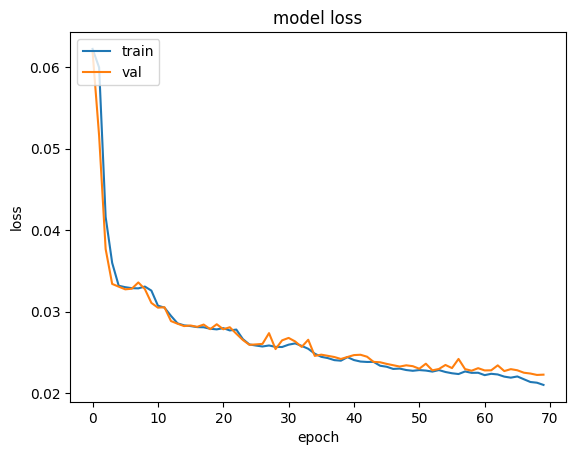

In [22]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [23]:
lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.00025, decay_steps=200, decay_rate=0.995)
optim = keras.optimizers.Adam(learning_rate = lr_schedule)                  # clipnorm=2.0
AE.compile(optimizer=optim,loss='mse')

In [24]:
history2 = AE.fit(img_train, img_train, batch_size=batch_size, validation_data=(img_valid, img_valid), epochs=30, steps_per_epoch=None)

Epoch 1/30
391/391 [==============================] - 40s 77ms/step - loss: 0.0206 - val_loss: 0.0221
Epoch 2/30
391/391 [==============================] - 30s 78ms/step - loss: 0.0204 - val_loss: 0.0222
Epoch 3/30
391/391 [==============================] - 28s 73ms/step - loss: 0.0203 - val_loss: 0.0222
Epoch 4/30
391/391 [==============================] - 29s 73ms/step - loss: 0.0202 - val_loss: 0.0222
Epoch 5/30
391/391 [==============================] - 29s 73ms/step - loss: 0.0201 - val_loss: 0.0221
Epoch 6/30
391/391 [==============================] - 29s 74ms/step - loss: 0.0200 - val_loss: 0.0221
Epoch 7/30
391/391 [==============================] - 28s 73ms/step - loss: 0.0200 - val_loss: 0.0222
Epoch 8/30
391/391 [==============================] - 29s 73ms/step - loss: 0.0199 - val_loss: 0.0222
Epoch 9/30
391/391 [==============================] - 29s 75ms/step - loss: 0.0198 - val_loss: 0.0222
Epoch 10/30
391/391 [==============================] - 29s 75ms/step - loss: 0.019

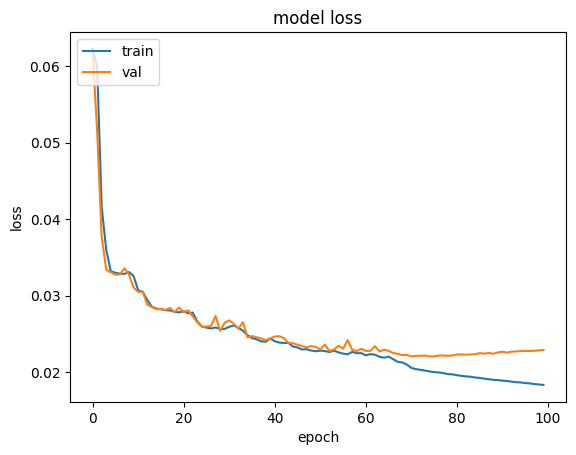

In [25]:
plt.plot(history.history['loss']+history2.history['loss'])
plt.plot(history.history['val_loss']+history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [26]:
def plot_reconstruction(set, name,seed_val, epochs):     #name should be either 'training' or 'validation'
  np.random.seed(seed_val)

  tg_indices = np.random.randint(0,set.shape[0],size = 16)
  img_sample = tf.convert_to_tensor(np.array(set)[tg_indices])
  z_sample = encoder(img_sample)
  img_recon = decoder(z_sample)

  recon = plt.figure(figsize=(9,4))    # it's weird that the order of axes in figsize is the opposite to that in add_subplot
  recon.suptitle('Reconstructed images (right) from the ' + name + '-set after ' + str(epochs) + ' epochs: no regularisation in the encoder, decoder, latent_dim = 512', fontweight= 'bold', y=0.93)

  recon.tight_layout()

  for i in range(36):
    recon.add_subplot(4,9,i+1)
    j = int(np.floor(i/9))
    if (i%9) <4:
      img = set[tg_indices[j*4 + (i%9)]]
      plt.imshow(img)
      plt.axis('off')
    elif (i%9)==4:
      img = np.ones((32,32,3))
      plt.imshow(img)
      plt.axis('off')
    else:
      img = img_recon[j*4 + (i%9) - 5]
      plt.imshow(img)
      plt.axis('off')

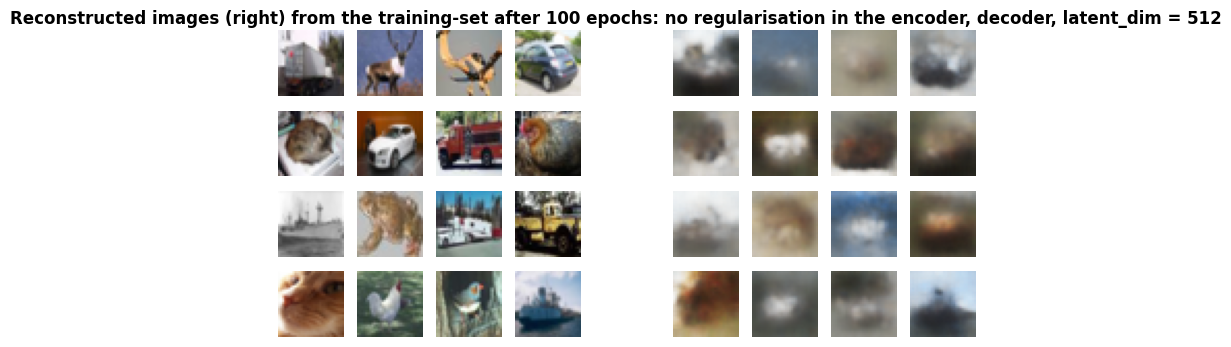

In [27]:
plot_reconstruction(img_train, 'training', 123, 100)

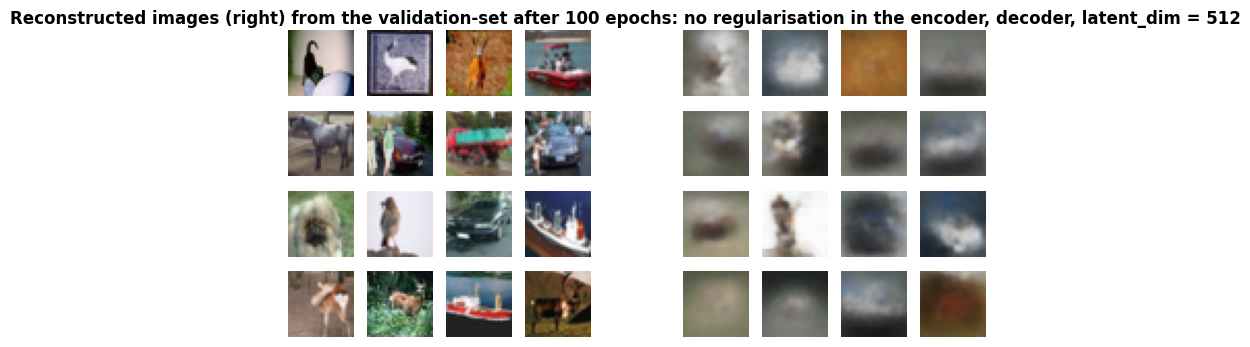

In [28]:
plot_reconstruction(img_valid, 'validation', 123, 100)